In [1]:
import numpy as np
import torch
from matplotlib import cm
import matplotlib.pyplot as plt

x = np.random.uniform(-1.0, 1.0, (200, 1))
y = x**2

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

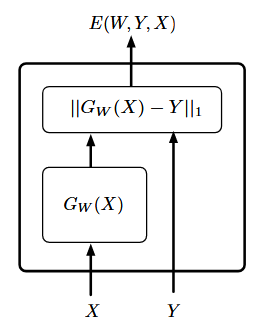

In [2]:
class Regressor(torch.nn.Module):
    def __init__(self, hidden_uts=20, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # self.W1 = torch.nn.Parameter(torch.rand(1, hidden_uts)*1**-0.5)
        # self.W1 = torch.nn.Parameter(torch.rand(1, hidden_uts)*(hidden_uts/(hidden_uts+1))**0.5)
        self.W1 = torch.nn.Parameter(torch.rand(1, hidden_uts))
        self.b1 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        # self.W2 = torch.nn.Parameter(torch.rand(hidden_uts, hidden_uts)*(2/(hidden_uts+hidden_uts))**0.5)
        self.W2 = torch.nn.Parameter(torch.rand(hidden_uts, hidden_uts))
        self.b2 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.out_proj = torch.nn.Parameter(torch.rand(hidden_uts, 1)*(hidden_uts**-0.5))
        # self.out_proj = torch.nn.Parameter(torch.rand(hidden_uts, 1)*(2/(hidden_uts+1))**0.5)

        torch.nn.init.xavier_uniform_(self.W1)
        torch.nn.init.xavier_uniform_(self.W2)

    def forward(self, x, y):
        act = torch.nn.functional.tanh
        x = act(x @ self.W1 + self.b1)
        x = act(x @ self.W2 + self.b2)

        x = x @ self.out_proj
        return x, y

Energy function
$E(W,Y^i,X^i)= ||G_W(X^i)-Y^i||$

Loss function
* $\mathcal{S}$: Dataset of inputs and labels.
* $P$: Number of samples in the dataset. \
$L(W,\mathcal{S}) = \frac{1}{P}\sum_{i=1}^P E(W,Y^i,X^i)$

In [3]:
def energy_fn(model, x, y):
    pred_y, encod_y = model(x, y)

    if pred_y.shape[1] > 1:
        energy = torch.abs(pred_y - encod_y).sum(dim = -1)
    else:
        energy = torch.abs(pred_y - encod_y)
    return energy

def energyloss_fn(model, x, y, energy_fn):
    energies = energy_fn(model, x, y)

    return energies

def plot_surfacce(model, x, y, energy_fn, **kwargs):
    
    x_space = np.linspace(-1, 1, 100)
    y_space = np.linspace(-2,2, 200)
    x_space, y_space = np.meshgrid(x_space, y_space)

    x_ = torch.tensor(x_space, dtype=torch.float32, device=x.device).reshape(-1, 1)
    y_ = torch.tensor(y_space, dtype=torch.float32, device=y.device).reshape(-1, 1)
    z_space = energy_fn(model, x_, y_)
    z_space = z_space.reshape(x_space.shape).detach().cpu().numpy()

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(x_space, y_space, z_space, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False, alpha=0.7)
    
    real_labels_energy = energy_fn(model, x, y).detach().cpu().numpy()

    ax.scatter(x.cpu(), y.cpu(), real_labels_energy, s=50, color='green')
    ax.view_init(elev=kwargs.get('elev', 60), azim=kwargs.get('azim', 70))
    plt.show()

def training(model, loss_fn, x, y, energy_fn, epochs=100, lr = 0.1, batch_size = 8, chart_epochs=[1,10,60,100]):
    n = x.shape[0]

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(epochs):
        perm = torch.randperm(n, device=x.device)

        losses = []

        for start in range(0, n, batch_size):
            optim.zero_grad()
            
            idx = perm[start:start + batch_size]
            x_batch, y_batch = x[idx], y[idx]
            loss_val = loss_fn(model, x_batch, y_batch, energy_fn).mean()
            losses.append(loss_val.item())


            loss_val.backward()
            optim.step()
            # for p in model.parameters():
            #     if p.grad is not None:
            #         p.data -= lr * p.grad
            #         p.grad.zero_()

        avg_loss = sum(losses)/len(losses)

        if (i+1)%10 == 0 or i == 0 or i == epochs-1:
            print(f"Loss step {i+1:>5}: {avg_loss:>10,.4f}")

        if (i+1) in chart_epochs:
            plot_surfacce(model, x, y, energy_fn)

Loss step     1:     0.2579


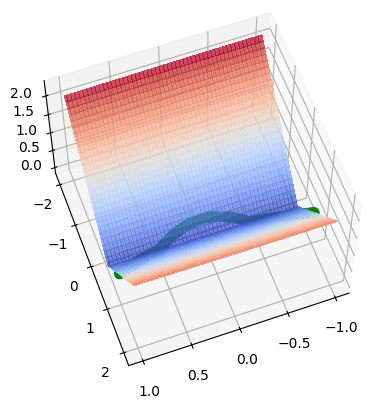

Loss step    10:     0.2337


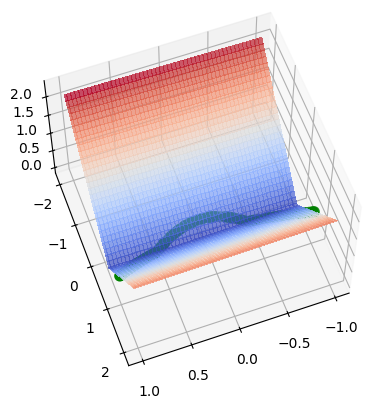

Loss step    20:     0.2342
Loss step    30:     0.2304
Loss step    40:     0.2236
Loss step    50:     0.2355
Loss step    60:     0.2319


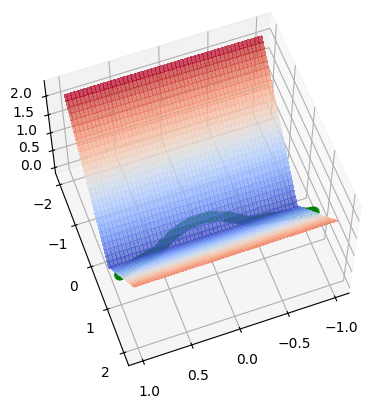

Loss step    70:     0.2317
Loss step    80:     0.2273
Loss step    90:     0.0439
Loss step   100:     0.0304


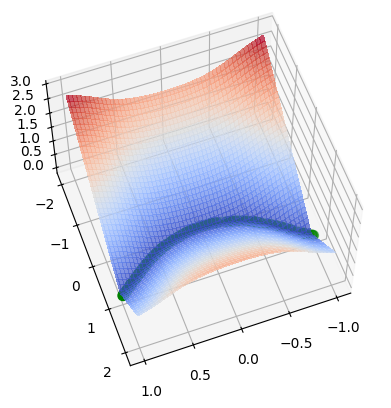

In [4]:
regressor = Regressor()

training(regressor, energyloss_fn, x, y, energy_fn, lr=0.01, epochs = 100, batch_size=4)

## Second architecture

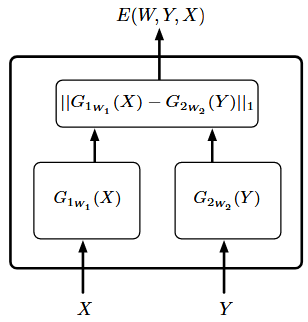

In [5]:
class JEA(torch.nn.Module):
    def __init__(self, hidden_uts=10, out_units=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # encode x
        self.xW1 = torch.nn.Parameter(torch.rand(1, hidden_uts))
        self.xb1 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.xW2 = torch.nn.Parameter(torch.rand(hidden_uts, hidden_uts))
        self.xb2 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.xout_proj = torch.nn.Parameter(torch.rand(hidden_uts, out_units)*(hidden_uts**-0.5))

        torch.nn.init.xavier_uniform_(self.xW1)
        torch.nn.init.xavier_uniform_(self.xW2)

        # encode y
        self.yW1 = torch.nn.Parameter(torch.rand(1, hidden_uts))
        self.yb1 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.yW2 = torch.nn.Parameter(torch.rand(hidden_uts, hidden_uts))
        self.yb2 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.yout_proj = torch.nn.Parameter(torch.rand(hidden_uts, out_units)*(hidden_uts**-0.5))

        torch.nn.init.xavier_uniform_(self.yW1)
        torch.nn.init.xavier_uniform_(self.yW2)
        

    def forward(self, x, y):
        act = torch.nn.functional.tanh
        x = act(x @ self.xW1 + self.xb1)
        x = act(x @ self.xW2 + self.xb2)
        x = x @ self.xout_proj

        y = act(y @ self.yW1 + self.yb1)
        y = act(y @ self.yW2 + self.yb2)
        y = y @ self.yout_proj
        return x, y

Energy function
$E(W,Y^i,X^i)= ||G_{W_1}(X^i)-G_{W_2}(Y^i)||$

Loss function
* $\mathcal{S}$: Dataset of inputs and labels.
* $P$: Number of samples in the dataset. \
$L(W,\mathcal{S}) = \frac{1}{P}\sum_{i=1}^P E(W,Y^i,X^i)$

Loss step     1:     0.2794


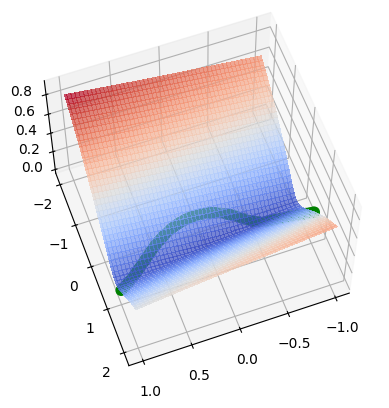

Loss step    10:     0.0028


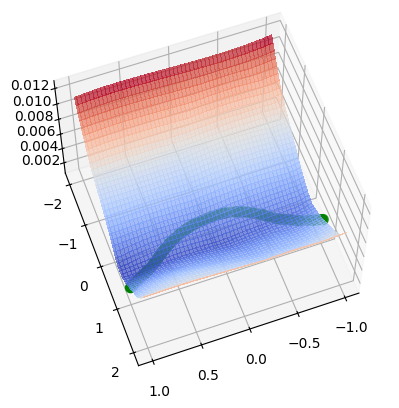

Loss step    20:     0.0001
Loss step    30:     0.0001
Loss step    40:     0.0002
Loss step    50:     0.0002
Loss step    60:     0.0021


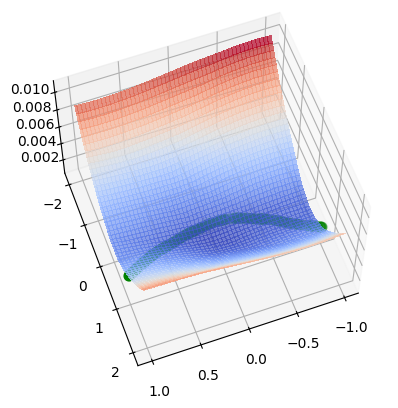

Loss step    70:     0.0003
Loss step    80:     0.0090
Loss step    90:     0.0000
Loss step   100:     0.0005


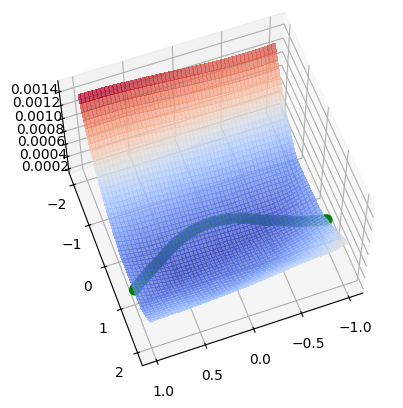

In [6]:
model = JEA()

training(model, energyloss_fn, x, y, energy_fn, lr=0.01, epochs = 100, batch_size=4)

## Using a better energy function for more complex archs

Energy function
$E(W,Y^i,X^i)= ||G_{W_1}(X^i)-G_{W_2}(Y^i)||$

Loss function
* $\mathcal{S}$: Dataset of inputs and labels.
* $P$: Number of samples in the dataset.
* $m$: Margin.
* $\bar{Y}^i$: the most offending incorrect answer is the answer that has the lowest energy among all answers that are at least $\epsilon$ away from the correct answer. \
$L_{\text{sq-sq}}(W,\mathcal{S}) = \frac{1}{P}\sum_{i=1}^P E(W,Y^i,X^i)^2 - (\max(0, m - E(W,\bar{Y}^i, X^i)))^2$

In [7]:
def find_the_most_effending_answers(model, x, y, epsilon=0.01, steps=200, lr=0.001, log=False, shift_answers=True, samples=1):
    for p in model.parameters():
        p.requires_grad = False

    # Repeat x some "samples" amount of times to not get trapped in local minima
    x_ = x.repeat(1, samples).reshape(x.shape[0]*samples,1)
    

    optim_y = torch.rand(x_.shape, device=y.device)
    optim_y = (optim_y - 0.5)*2 # Unif(-2,2). It works even though negative values are not part of the y domain
    optim_y.requires_grad = True

    for step in range(steps):
        loss = energy_fn(model, x_, optim_y)
        if log:
            print(f"loss step {step+1:>4}: {loss.reshape(-1, samples).min(dim=1)[0].mean().item():>7,.4f}")
        init_grad = torch.ones_like(loss, device=loss.device)
        loss.backward(init_grad)

        optim_y.data -= lr * optim_y.grad

        optim_y.grad.zero_()

    optim_y.requires_grad = False

    # Take the y with less energy value among the samples
    loss = energy_fn(model, x_, optim_y).reshape(-1, samples)
    min_idx = loss.argmin(1)
    optim_y = optim_y.reshape(-1, samples, 1)[torch.arange(0,x.shape[0]), min_idx]

    for p in model.parameters():
        p.requires_grad = True

    if shift_answers:
        # Add an epsilon if the minimum is not at least epsilon from the correct answer
        epsilon = (torch.abs(optim_y - y)-epsilon).clip(None, 0)
        # Shift the offending value towards the opposite of the correct answer
        epsilon *= torch.where(optim_y - y >= 0, -1.0, 1.0) # the signs are inverted since epsilon is negative
        optim_y += epsilon
    return optim_y

### Optimizing through the energy landscape gives a similar result that using the regressor directly\

The avg. absolute difference between the regressor answers and the real answers:

In [8]:
optim_y_regressor, _ = regressor(x, y)
torch.abs(optim_y_regressor - y).mean()

tensor(0.0188, grad_fn=<MeanBackward0>)

The avg. absolute difference between the answers produced by optimization and the real answers:

In [11]:
optim_y = find_the_most_effending_answers(regressor, x, y, steps=100, lr=0.01, log=True, shift_answers=False, samples=5)

loss step    1:  0.1829
loss step    2:  0.1733
loss step    3:  0.1641
loss step    4:  0.1554
loss step    5:  0.1472
loss step    6:  0.1395
loss step    7:  0.1323
loss step    8:  0.1255
loss step    9:  0.1191
loss step   10:  0.1127
loss step   11:  0.1069
loss step   12:  0.1012
loss step   13:  0.0957
loss step   14:  0.0904
loss step   15:  0.0856
loss step   16:  0.0809
loss step   17:  0.0766
loss step   18:  0.0721
loss step   19:  0.0682
loss step   20:  0.0640
loss step   21:  0.0606
loss step   22:  0.0567
loss step   23:  0.0537
loss step   24:  0.0504
loss step   25:  0.0479
loss step   26:  0.0447
loss step   27:  0.0425
loss step   28:  0.0396
loss step   29:  0.0377
loss step   30:  0.0351
loss step   31:  0.0335
loss step   32:  0.0310
loss step   33:  0.0294
loss step   34:  0.0272
loss step   35:  0.0261
loss step   36:  0.0241
loss step   37:  0.0235
loss step   38:  0.0216
loss step   39:  0.0211
loss step   40:  0.0193
loss step   41:  0.0188
loss step   42: 

In [12]:
torch.abs(optim_y - y).mean()

tensor(0.0189)

First sample comparison

In [13]:
print(f"Regressor answer: {optim_y_regressor[0].item():.4f}, Optimized answer: {optim_y[0].item():.4f}, Real answer: {y[0].item():.4f}")

Regressor answer: 0.2921, Optimized answer: 0.2920, Real answer: 0.3132


### Using the Square-Square loss to train the energy model

In [14]:
def sqsqloss_fn(model, x, y, energy_fn, m=0.1, intra_steps=100, epsilon=0.1, samples=1):
    energies = energy_fn(model, x, y)

    # off_y = y + m
    # off_energies = energy_fn(model, x, off_y)
    # off_y = y - m
    # off_energies2 = energy_fn(model, x, off_y)
    # off_energies = torch.min(off_energies, off_energies2)

    # with torch.no_grad():
    #     optim_y, _ = model(x, y)
    # # Add an epsilon if the minimum is not at least epsilon from the correct answer
    # epsilon = (torch.abs(optim_y - y)-epsilon).clip(None, 0)
    # # Shift the offending value towards the opposite of the correct answer
    # epsilon *= torch.where(optim_y - y >= 0, -1.0, 1.0) # the signs are inverted since epsilon is negative
    # off_y = optim_y

    # Optim method
    off_y = find_the_most_effending_answers(model, x, y, lr=0.02, steps=intra_steps, epsilon=epsilon, samples=samples)
    
    off_energies = energy_fn(model, x, off_y)

    loss = energies**2 + (torch.clip(m - off_energies, 0, None))**2

    return loss

Loss step     1:     0.2128


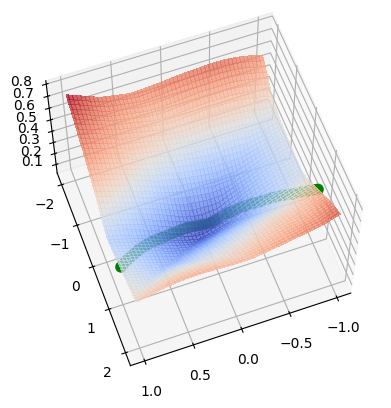

Loss step    10:     0.0156


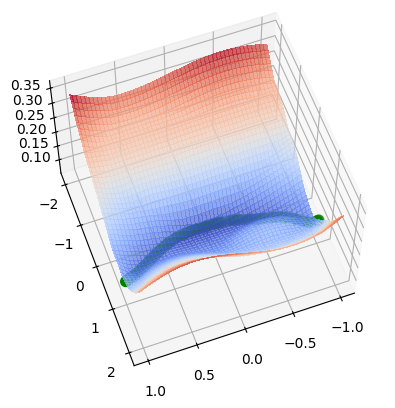

Loss step    20:     0.0150
Loss step    30:     0.0149
Loss step    40:     0.0157
Loss step    50:     0.0153
Loss step    60:     0.0167


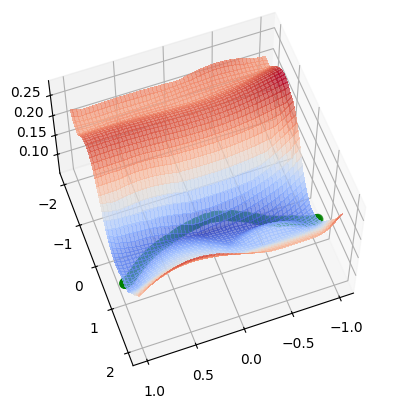

Loss step    70:     0.0152
Loss step    80:     0.0142
Loss step    90:     0.0139
Loss step   100:     0.0133


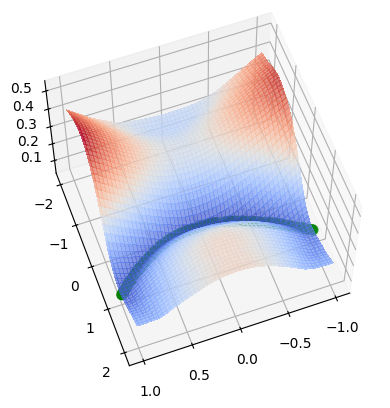

In [15]:
model = JEA()
model.cuda()

sqsqloss_fn_m = lambda model, x, y, energy_fn: sqsqloss_fn(model, x, y, energy_fn, 0.2, intra_steps=50, epsilon=0.001, samples=1)
# sqsqloss_fn_m = lambda model, x, y, energy_fn: sqsqloss_fn(model, x, y, energy_fn, 0.2, intra_steps=50, epsilon=0.001, samples=10) # Increasing the samples did not work
# sqsqloss_fn_m = lambda model, x, y, energy_fn: sqsqloss_fn(model, x, y, energy_fn, 0.5, intra_steps=50, epsilon=0.001)

training(model, sqsqloss_fn_m, x.cuda(), y.cuda(), energy_fn, lr=0.001, epochs = 100, batch_size=8)

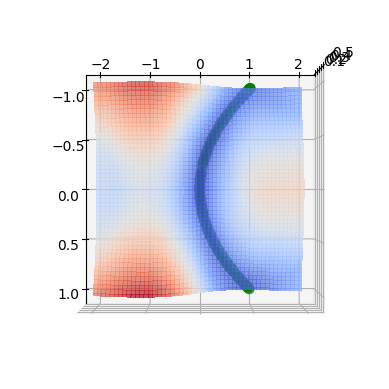

In [16]:
plot_surfacce(model, x.cuda(), y.cuda(), energy_fn, azim=-0, elev=90)

In [20]:
optim_y = find_the_most_effending_answers(model, x.cuda(), y.cuda(), steps=100, lr=0.02, log=True, shift_answers=False, samples=5)

loss step    1:  0.1024
loss step    2:  0.1012
loss step    3:  0.1001
loss step    4:  0.0991
loss step    5:  0.0980
loss step    6:  0.0970
loss step    7:  0.0961
loss step    8:  0.0951
loss step    9:  0.0942
loss step   10:  0.0933
loss step   11:  0.0925
loss step   12:  0.0916
loss step   13:  0.0908
loss step   14:  0.0900
loss step   15:  0.0892
loss step   16:  0.0885
loss step   17:  0.0877
loss step   18:  0.0870
loss step   19:  0.0863
loss step   20:  0.0857
loss step   21:  0.0850
loss step   22:  0.0844
loss step   23:  0.0839
loss step   24:  0.0833
loss step   25:  0.0828
loss step   26:  0.0822
loss step   27:  0.0817
loss step   28:  0.0812
loss step   29:  0.0807
loss step   30:  0.0803
loss step   31:  0.0798
loss step   32:  0.0793
loss step   33:  0.0789
loss step   34:  0.0785
loss step   35:  0.0780
loss step   36:  0.0777
loss step   37:  0.0773
loss step   38:  0.0769
loss step   39:  0.0765
loss step   40:  0.0762
loss step   41:  0.0759
loss step   42: 

In [21]:
energy_fn(model, x.cuda(), y.cuda()).mean()

tensor(0.0704, device='cuda:0', grad_fn=<MeanBackward0>)

In [22]:
torch.abs(optim_y - y.cuda()).mean()

tensor(0.0433, device='cuda:0')

### Negative log-likelihood loss

Energy function
$E(W,Y^i,X^i)= ||G_{W_1}(X^i)-G_{W_2}(Y^i)||$

Loss function
* $\mathcal{S}$: Dataset of inputs and labels.
* $P$: Number of samples in the dataset.
* $\beta$: Opposite of temperature \
$L_{\text{nll}}(W,\mathcal{S}) = \frac{1}{P}\sum_{i=1}^P E(W,Y^i,X^i) + \frac{1}{\beta}\log(\int_{y\in\mathcal{Y}} e^{-\beta E(W,y,X^i)})$

In [23]:
def nll_loss_fn(model, x, y, energy_fn, beta=1, n=100):
    energies = energy_fn(model, x, y)

    # for each x generate n samples of energy
    n_samples = n
    up_lim = 2
    low_lim = -2
    y_samples = torch.linspace(low_lim,up_lim,n_samples).reshape(1, -1)
    y_samples = y_samples + y
    sample_shape = y_samples.shape
    x_samples = x.repeat(n_samples, 1)
    samples_energy = energy_fn(model, x_samples, y_samples.reshape(-1, 1))
    samples_energy = samples_energy.reshape(sample_shape)
    
    integral = -beta* samples_energy
    integral = (integral.exp() * (up_lim-low_lim)/n_samples).sum(dim=1)

    loss = energies + (1/beta)*torch.log(integral)
    return loss

Loss step     1:     0.6797


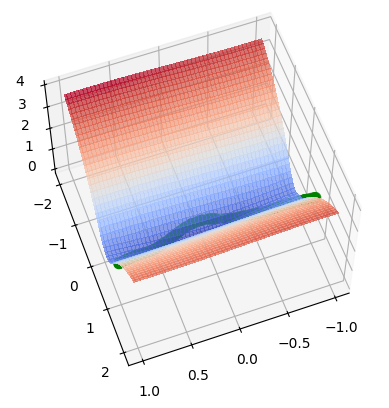

Loss step    10:     0.0538


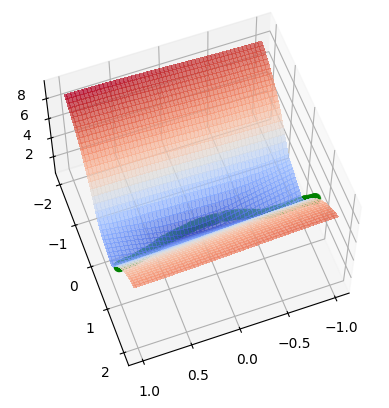

Loss step    20:    -0.2737
Loss step    30:    -0.6058
Loss step    40:    -1.1466
Loss step    50:    -1.5547
Loss step    60:    -1.8211


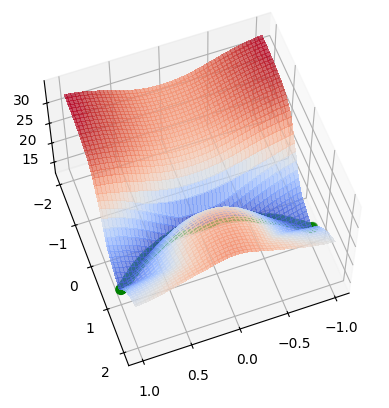

Loss step    70:    -1.9590
Loss step    80:    -2.0899
Loss step    90:    -2.1758
Loss step   100:    -2.2575


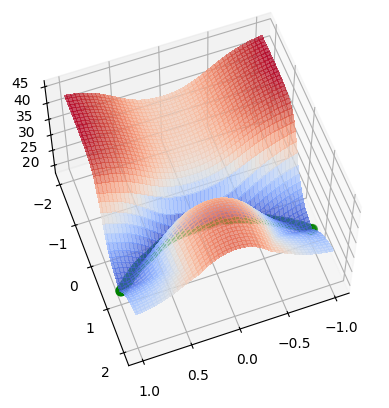

In [24]:
model = JEA()

nll_loss_fn_b = lambda model, x, y, energy_fn: nll_loss_fn(model, x, y, energy_fn, 1, n=200)

training(model, nll_loss_fn_b, x, y, energy_fn, lr=0.001, epochs = 100, batch_size=6)

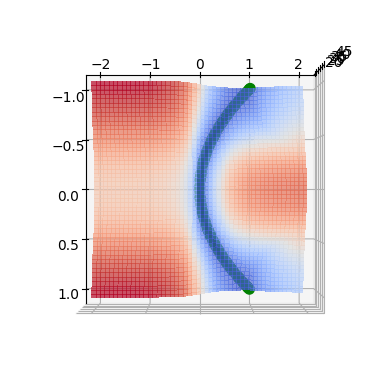

In [25]:
plot_surfacce(model, x, y, energy_fn, azim=-0, elev=90)

In [28]:
optim_y = find_the_most_effending_answers(regressor, x, y, steps=100, lr=0.01, log=True, shift_answers=False, samples=5)

loss step    1:  0.1761
loss step    2:  0.1666
loss step    3:  0.1575
loss step    4:  0.1487
loss step    5:  0.1411
loss step    6:  0.1328
loss step    7:  0.1258
loss step    8:  0.1181
loss step    9:  0.1121
loss step   10:  0.1053
loss step   11:  0.0999
loss step   12:  0.0940
loss step   13:  0.0896
loss step   14:  0.0842
loss step   15:  0.0803
loss step   16:  0.0754
loss step   17:  0.0718
loss step   18:  0.0669
loss step   19:  0.0637
loss step   20:  0.0594
loss step   21:  0.0565
loss step   22:  0.0525
loss step   23:  0.0498
loss step   24:  0.0464
loss step   25:  0.0442
loss step   26:  0.0414
loss step   27:  0.0397
loss step   28:  0.0373
loss step   29:  0.0357
loss step   30:  0.0335
loss step   31:  0.0321
loss step   32:  0.0303
loss step   33:  0.0290
loss step   34:  0.0272
loss step   35:  0.0261
loss step   36:  0.0243
loss step   37:  0.0233
loss step   38:  0.0215
loss step   39:  0.0207
loss step   40:  0.0190
loss step   41:  0.0184
loss step   42: 

In [29]:
torch.abs(optim_y - y).mean()

tensor(0.0192)